<center><h1>CSCI 5481 Final Course Project</h1>
    <h3>Brian Cooper</h3>
</center>

<hr>
<br>

<center><h1>Introduction</h1></center>

For my CSCI 5481 final course project, I wanted to compare quantum algorithms (algorithms designed to run on a quantum computer) to classical algorithms (algorithms designed to run on a "classical" computer). Classical computers run on binary logic, meaning the information stored on them is stored in discrete bits that take on a state of either 0 or 1. Quantum computers, on the other hand, operate on quantum information, which is stored in _quantum bits_ or "qubits." As qubits are subject to quantum phenomena, they can take on any number of states between and including 0 and 1 with a concept known as "superposition." This can explored further in Martin Giles' explanation of quantum computers on MIT Technology Review[<sup>1</sup>](#fn1), along with some more details about the mystical nature of quantum computers. Classical computers have been used extensively to solve machine learning problems, but quantum computing is a relatively new and smaller space. Through this project, I hoped to answer a basic question: are quantum computing algorithms useful and practical for working with bioinformatics machine learning problems? At the very least, I wanted to create a foundation for implementing the algorithms detailed below, one that can be expanded upon in the future. 

Quantum computing is very much in its infancy, but there have been strides from major companies such as IBM and Microsoft to open the field to interested individuals. There are several quantum computing projects being worked on right now with public access, including D-Wave Ocean[<sup>2</sup>](#fn2), IBM Q[<sup>3</sup>](#fn3) (further described below), and the Microsoft Q#[<sup>4</sup>](#fn4) language. I chose to go with IBM's _Qiskit_[<sup>5</sup>](#fn5) due to its relatively mature project status. Qiskit is a Python SDK designed to simulate quantum processes, and it also allows the ability to actually use a physical quantum computer (described below in _Some notes about Qiskit_. The logic behind the SDK is built upon the mathematics and ideas of quantum mechanics. Qiskit is designed to integrate with IBM Q, which includes the suite of devices being worked on in IBM's research group. Qiskit effectively accesses IBM Q, as well as something called _OpenQASM_[<sup>6</sup>](#fn6), which is considered a "Quantum Assembly Language" and is used to implement quantum circuitry close to the hardware.

There are not many options yet for testing quantum computing from a home computer, especially in the artificial intelligence/machine learning scene. Despite this, Qiskit includes a "quantum" support vector machine algorithm and a "classical" support vector machine algorithm for reference (which uses a radial basis kernel). Unfortunately, I don't have the capability nor understanding to implement other forms of quantum SVM, so the benchmarks below will only describe a comparison between QSVM and SVM (radial-basis kernel), both as currently implemented in Qiskit. This is an inherent shortcoming of my experiments that will be addressed further on, but still provides at least a basic benchmark to go off of. I hoped to stay within the Qiskit environment when running the experiments for this project.

With the two support vector machine algorithms picked out, I needed some biological datasets that could be used for classification, since SVM methods work very well for classification.

I chose to analyze five popular biological datasets from the UCI Machine Learning Repository[<sup>7</sup>](#fn7). They are:
- Breast Cancer Wisconsin (Diagnostic): https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
- Ecoli: https://archive.ics.uci.edu/ml/datasets/Ecoli
- Yeast: https://archive.ics.uci.edu/ml/datasets/Yeast
- Parkinson's: https://archive.ics.uci.edu/ml/datasets/Parkinsons
- Statlog Heart: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29

All of the above datasets have been previously used for classification training and testing with various methods, including (but certainly not limited to) various kernel SVM methods.

Qiskit isn't the most straightforward thing to learn, especially since the project is so young (this is reflected in the documentation &#8213; there are currently many pages in the documentation that are blank). I used a combination of articles, the official documentation, looking through the source code, and the official Qiskit tutorials[<sup>8</sup>](#fn8) to piece together the code in `data.py` and `svm.py`.

<br>
<center><h1>Methods</h1></center>

In [1]:
%matplotlib inline
from data import *
from svm import *

/home/brian/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/api_v2/clients/websocket.py:85: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def _connect(self, url):
/home/brian/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/api_v2/clients/websocket.py:133: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def get_job_status(self, job_id, timeout=None):


## Plotting the Data

The below plots have their dimensionality reduced using principal component analysis, where I project the input dimensionality (training_size + test_size) to n dimensions. All of these n values are set to 2 to match the number of qubits used for classification &#8213; the 2 qubits are entangled ("linked", but it's a bit more complicated than that) with each other. Entanglement is characterized by a lack of indepedence among the components in a system. In this case, the system is two qubits and observing the value of one qubit provides information about the other. Entanglement provides the groundwork for topological quantum computing[<sup>9</sup>](#fn9), which is currently largely theoretical, but much research is being performed in this field. The University of Minnesota has recently started researching topological quantum computing[<sup>10</sup>](#fn10).

The PCA dimensionality can be further explored in `data.py`, where I read in each of the input datasets and process them. The quantum algorithm construction can be viewed in `svm.py`, which also includes code for the SVM reference algorithm built into Qiskit.

The entire datasets are used to build a model. I used sklearn's train_test_split to split the model into 70% training and 30% testing. The training_size and test_size parameters passed in below are used as sample indices for training the model.

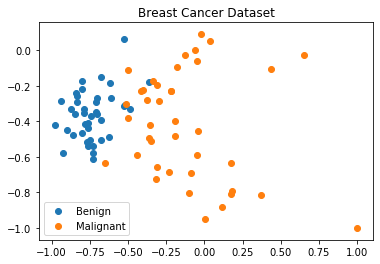

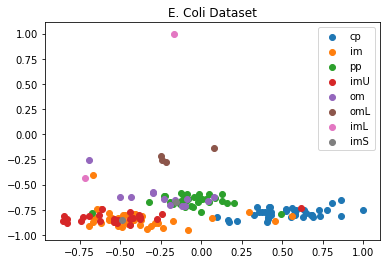

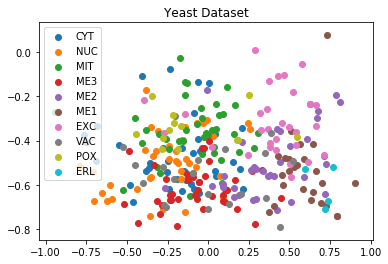

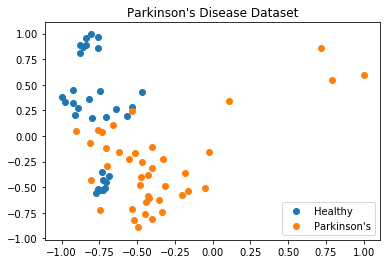

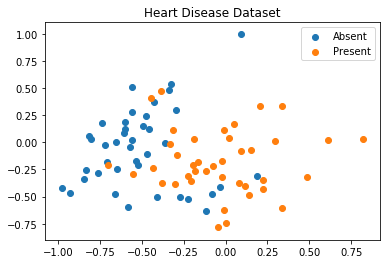

In [2]:
# Breast Cancer Wisconsin
b_sample_total, b_training_input, b_test_input, b_class_labels = breast_cancer(training_size=40, test_size=10, n=2, PLOT_DATA=True)

# Ecoli
e_sample_total, e_training_input, e_test_input, e_class_labels = ecoli(training_size=40, test_size=10, n=2, PLOT_DATA=True)

# Yeast
y_sample_total, y_training_input, y_test_input, y_class_labels = yeast(training_size=40, test_size=10, n=2, PLOT_DATA=True)

# Parkinson's
p_sample_total, p_training_input, p_test_input, p_class_labels = parkinson(training_size=40, test_size=10, n=2, PLOT_DATA=True)

# Heart
h_sample_total, h_training_input, h_test_input, h_class_labels = heart(training_size=40, test_size=10, n=2, PLOT_DATA=True)

<br>
<center><h1>Experiments</h1></center>

## Applying Quantum Support Vector Machine (QSVM)
The quantum support vector machine algorithm uses the traditional support vector machine methodology as a foundation. QSVM uses a quantum processor to directly estimate the kernel in the feature space.

The quantum algorithms are run on a simulator to make this code more portable, but actual IBM Q devices can be accessed through the cloud. An account is required for this, and an API key with that account can be integrated into the code in `svm.py`, along with changing the backend from `qasm_simulator` to a device address. All of this is explained at the Qiskit IBMQ Provider Github repository[<sup>11</sup>](#fn11).

In [3]:
# b_result_quantum = quantum_svm(b_training_input, b_test_input, b_class_labels, 2)
# print("Breast Cancer Wisconsin QSVM classification done")

# e_result_quantum = quantum_svm(e_training_input, e_test_input, e_class_labels, 2)
# print("E. Coli QSVM classification done")

# y_result_quantum = quantum_svm(y_training_input, y_test_input, y_class_labels, 2)
# print("Yeast QSVM classification done")

# p_result_quantum = quantum_svm(p_training_input, p_test_input, p_class_labels, 2)
# print("Parkinson's QSVM classification done")

# h_result_quantum = quantum_svm(h_training_input, h_test_input, h_class_labels, 2)
# print("Heart QSVM classification done")

## Applying "Classical" Support Vector Machine (SVM) for Reference
Qiskit Aqua includes a classical SVM algorithm built-in; I believe it is a wrapper around sklearn's SVM algorithm with the radial-basis (RBF) kernel. Unfortunately, this cannot be changed, but other SVM kernels could be directly used with sklearn. I wanted to keep the tests as controlled as possible and see how QSVM and SVM compare directly within their own library, so opted to stay within the Qiskit framework for the actual SVM classification. The classical algorithms in Qiskit are, after all, included to serve as a reference point for the included quantum algorithms.

For a more robust experiment, however, it would probably be useful to compare different kernels, especially considering the widely varying distributions of the five datasets used here.

In [4]:
b_result_classical = classical_svm(b_training_input, b_test_input, b_class_labels, 2)
print("Breast Cancer Wisconsin SVM classification done")

e_result_classical = classical_svm(e_training_input, e_test_input, e_class_labels, 2)
print("E. Coli SVM classification done")

y_result_classical = classical_svm(y_training_input, y_test_input, y_class_labels, 2)
print("Yeast SVM classification done")

p_result_classical = classical_svm(p_training_input, p_test_input, p_class_labels, 2)
print("Parkinson's SVM classification done")

h_result_classical = classical_svm(h_training_input, h_test_input, h_class_labels, 2)
print("Heart SVM classification done")

Breast Cancer Wisconsin SVM classification done
E. Coli SVM classification done
Yeast SVM classification done
Parkinson's SVM classification done
Heart SVM classification done


## Comparing Classical SVM and QSVM

I used the accuracy results as a metric to measure the performance.

In [5]:
print("Breast Cancer Dataset Accuracy")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(b_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(b_result_quantum['testing_accuracy']))
print("------------------------------\n")

print("   E. Coli Dataset Accuracy   ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(e_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(e_result_quantum['testing_accuracy']))
print("------------------------------\n")

print("    Yeast Dataset Accuracy    ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(y_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(y_result_quantum['testing_accuracy']))
print("------------------------------\n")

print(" Parkinson's Dataset Accuracy ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(p_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(p_result_quantum['testing_accuracy']))
print("------------------------------\n")

print("    Heart Dataset Accuracy    ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(h_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(h_result_quantum['testing_accuracy']))
print("------------------------------\n")

Breast Cancer Dataset Accuracy
------------------------------
SVM (Radial Basis):       0.75
------------------------------

   E. Coli Dataset Accuracy   
------------------------------
SVM (Radial Basis):       0.90
------------------------------

    Yeast Dataset Accuracy    
------------------------------
SVM (Radial Basis):       0.45
------------------------------

 Parkinson's Dataset Accuracy 
------------------------------
SVM (Radial Basis):       0.40
------------------------------

    Heart Dataset Accuracy    
------------------------------
SVM (Radial Basis):       0.60
------------------------------



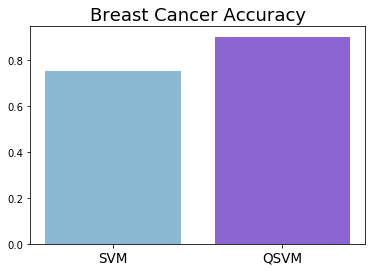

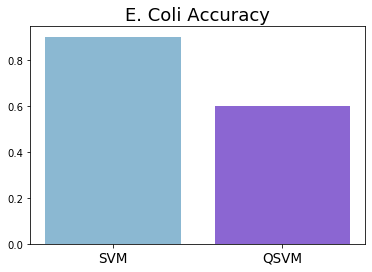

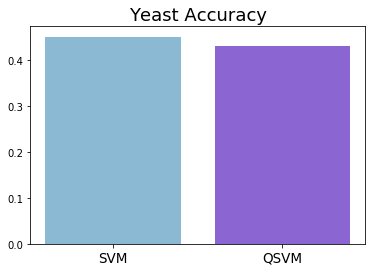

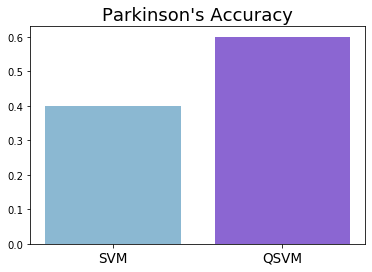

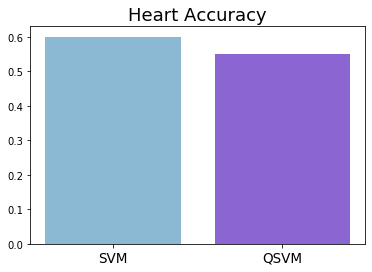

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2)
b_accuracy = [0.75, 0.9]
e_accuracy = [0.9, 0.6]
y_accuracy = [0.45, 0.43]
p_accuracy = [0.4, 0.6]
h_accuracy = [0.6, 0.55]

# Breast Cancer Accuracy
plt.bar(x, b_accuracy, color=[(0.43, 0.65, 0.78, 0.8), (0.43, 0.25, 0.78, 0.8)])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("Breast Cancer Accuracy", fontsize=18)
plt.show()

# Ecoli Accuracy
plt.bar(x, e_accuracy, color=[(0.43, 0.65, 0.78, 0.8), (0.43, 0.25, 0.78, 0.8)])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("E. Coli Accuracy", fontsize=18)
plt.show()

# Yeast Accuracy
plt.bar(x, y_accuracy, color=[(0.43, 0.65, 0.78, 0.8), (0.43, 0.25, 0.78, 0.8)])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("Yeast Accuracy", fontsize=18)
plt.show()

# Parkinson's Accuracy
plt.bar(x, p_accuracy, color=[(0.43, 0.65, 0.78, 0.8), (0.43, 0.25, 0.78, 0.8)])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("Parkinson's Accuracy", fontsize=18)
plt.show()

# Heart Accuracy
plt.bar(x, h_accuracy, color=[(0.43, 0.65, 0.78, 0.8), (0.43, 0.25, 0.78, 0.8)])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("Heart Accuracy", fontsize=18)
plt.show()

<br>
<center><h1>Discussion</h1></center>

A parameter you can specify when constructing an algorithm in Qiskit is the number of _shots_, which specifies how many times a quantum circuit is repeated. The reason it's desirable to repeat the circuit multiple times is to gradually build up distribution statistics of the logical circuit results. In Qiskit, this number is 1024 by default. I reduced this value to 256 to speed up the computation time. 

Even when reducing the number of shots to 256, the quantum algorithms still took a very long time compared to classical algorithms, such as the radial basis kernel SVM used above. Overall, each of the five quantum algorithm runs (with all 256 shots included) took several hours, while all five of the classical algorithms completed in under a minute. Keep in mind that these quantum experiments were performed on a simulator rather than physical quantum devices (such as IBM Q), so the performance would likely improve on a physical quantum computer. To adjust this, the backend for each Aqua parameter list can be changed in the file `svm.py`, as described in the _Applying Quantum Support Vector Machine (QSVM)_ section above. Assuming the QASM simulator is accurate and factors in noise and other environmental factors, using a physical IBM Q backend should produce similar results to those above with faster speed. There is some commented code in `svm.py` that allows usage of GPU acceleration for the circuit backend. Augmenting the circuit runs with a GPU would likely improve the performance as well.

As mentioned in the introduction, the experiments above only compare QSVM as it is currently implemented in Qiskit and SVM with a RBF kernel. This was done to keep the experiments within Qiskit's library. More SVM kernels can be used on the data, and more algorithms aside from SVM can be used on the data. This would provide more insight in the experiments. As mentioned in the introduction, I tried to stay within Qiskit's environment.

The quantum implementation of SVM created a model with better accuracy on the breast cancer dataset (90% vs. 75%) and the Parkinson's dataset (60% vs. 40%). For the yeast and heart datasets, the quantum algorithm was very close behind in accuracy (43% vs. 45% and 55% vs. 60%, respectively). The E. coli dataset is the only dataset where the RBF SVM had a very large accuracy improvement over the quantum SVM (60% vs. 90%). As mentioned in the previous paragraph, it would be ideal to perform other quantum machine learning algorithms on the data to provide more benchmarks. Precision, recall, and F1-score are some measures that can further be used to analyze the experimental output.

Only accuracy was compared on these datasets, as that is all I could find natively in Qiskit to analyze model performance with the SVM algorithms above. In the future, I'm sure more metrics will include native support, and more metrics could be added manually since the class predictions and true class values are contained within the Qiskit SVM result structure.

As Qiskit is a young project, many of the algorithms contained within are largely proof-of-concept. As the project matures, the algorithms will be optimized and will naturally become more performant. The documentation will concurrently be improved, especially considering that Qiskit is an open-source project. Other quantum computing projects will follow suit: over time, utilizing quantum technology will become more accessible and robust. This is an exciting and rapidly-changing field that may be very useful in all sorts of applications. Even though the experiments only involved comparing the two SVM algorithms currently shipped with Qiskit, this demonstration shows that it is possible to already use quantum algorithms without too much difficulty. Qiskit in particular abstracts away from the physics and digital logic quite highly, at least for quickly spinning up an algorithm without too much tuning. Machine learning models built with a quantum foundation may be a useful tool to add when trying different algorithms on data.

Overall, I think the quantum computing space is definitely something to consider for future work. Quantum computers will supposedly be excellent at solving optimization problems, which are at the core of artificial intelligence and machine learning problems. Thus, I see bioinformatics enjoying a surge of innovation as quantum computers establish their place in society. 

As a final note, another interesting project that quantum computers are expected to be good at solving are modeling problems. Protein folding, for example, is a highly complex phenomenon that is a very expensive computational process. Since theoretical quantum computers are able to calculate multiple solutions "at once," they should help calculate and model this significantly faster than classical computers. This is one of many applications that will likely be improved with the aid of quantum computation.

<br>
<center><h1>References</h1></center>

1. <span id="fn1">Giles, Martin. “Explainer: What Is a Quantum Computer?” _MIT Technology Review_, https://www.technologyreview.com/s/612844/what-is-quantum-computing/</span>
2. <span id="fn2">_D-Wave’s Ocean Software._ https://ocean.dwavesys.com/.</span>
3. <span id="fn3">“IBM Research AI.” _IBM Research AI_, 5 June 2018, https://www.research.ibm.com/ibm-q/.</span>
4. <span id="fn4">_The Q# Programming Language._ https://docs.microsoft.com/en-us/quantum/language/.</span>
5. <span id="fn5">_Qiskit | Quantum Information Science Kit._ https://qiskit.org.</span>
6. <span id="fn6">Cross, Andrew W., et al. _Open Quantum Assembly Language._ July 2017. arxiv.org, https://arxiv.org/abs/1707.03429v2.</span>
7. <span id="fn7">_UCI Machine Learning Repository._ https://archive.ics.uci.edu/ml/.</span>
8. <span id="fn8">_A Collection of Jupyter Notebooks from the Community and Qiskit Developers Showing How to Use Qiskit: Qiskit/Qiskit-Tutorials._ 2017. Qiskit, 2019. GitHub, https://github.com/Qiskit/qiskit-tutorials.</span>
9. <span id="fn9">Lahtinen, Ville, and Jiannis K. Pachos. _A Short Introduction to Topological Quantum Computation._ May 2017. arxiv.org, doi:10.21468/SciPostPhys.3.3.021.</span>
10. <span id="fn10">_University to Lead $2.25 Million Grant for Developing next-Generation Quantum Computer | College of Science and Engineering._ https://cse.umn.edu/college/news/university-lead-225-million-grant-developing-next-generation-quantum-computer.</span>
11. <span id="fn11">_Qiskit Provider for Accessing the Quantum Devices and Simulators at IBMQ: Qiskit/Qiskit-Ibmq-Provider._ 2018. Qiskit, 2019. GitHub, https://github.com/Qiskit/qiskit-ibmq-provider.</span>